In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
import fiona

%matplotlib inline

'd'

In [2]:
#------------------------------------------------------------------------------
def get_dir(tmc):
    key = {'i' : ['+', 'P'],
          'd' : ['-', 'N']}

    for d, c in key.iteritems():
        if tmc[3] in c: 
            return d

#------------------------------------------------------------------------------
def find_mp(df_tmc, srs, lrs_gdf, buf_st, buf_inc):

    idx = df_tmc.index
    res_df = pd.DataFrame()
    buf = buf_st

    while len(idx) > 0:
        idx_ = idx
        st_gdf = GeoDataFrame(df_tmc.loc[idx,:], 
                              geometry=srs.loc[idx].buffer(buf))
        full_gdf = gpd.sjoin(st_gdf, lrs_gdf, op='contains')
        full_gdf = full_gdf[(full_gdf.road.map(int) == full_gdf.RouteID.map(int)) &
                            (full_gdf.index.map(get_dir) == full_gdf.Direction)]
        res_df = pd.concat([res_df, full_gdf])

        idx = df_tmc.drop(res_df.index, axis=0).index.tolist()
        buf+=buf_inc

    res_df = res_df.groupby(res_df.index).aggregate({'RouteID' : 'mean',
                                                     'SRMP' : 'mean',
                                                     'AheadBackI' : lambda x: x.unique()[0],
                                                     'ARM' : 'mean'})
    
    return res_df

In [3]:
p_gis = '../RMAS-local/4 - GIS/Washington2017'
f_shp = 'LRS2017.shp'
p_tmc = '../RMAS-local/1 - Raw/SCR2017'
f_csv = 'TMC_Identification.csv'

lrs_f = os.path.join(p_gis, f_shp)
tmc_f = os.path.join(p_tmc, f_csv)

with fiona.open(lrs_f) as f:
    lrs_crs = f.crs
tmc_crs = {'init' : 'epsg:4326'}
    
cols = [u'tmc', u'road', u'direction', u'start_latitude', 
        u'start_longitude', u'end_latitude',
        u'end_longitude', u'miles']

df_tmc = pd.read_csv(tmc_f, usecols=cols, index_col='tmc')
df_tmc.index.name = 'tmc'
df_tmc.road = df_tmc.road.map(lambda x: int(x.split('-')[1]))

# define start end end point geometry Series from tmc dataframe
st_geom = [Point(xy) for xy in zip(df_tmc['start_longitude'], 
                                   df_tmc['start_latitude'])]
st_srs = GeoSeries(st_geom, crs=tmc_crs, index=df_tmc.index).to_crs(lrs_crs)

e_geom = [Point(xy) for xy in zip(df_tmc['end_longitude'], 
                                   df_tmc['end_latitude'])]
e_srs = GeoSeries(e_geom, crs=tmc_crs, index=df_tmc.index).to_crs(lrs_crs)

# get bounding box
bds = pd.concat([st_srs, e_srs]).buffer(50).bounds
bbox = (bds.minx.min(), bds.miny.min(), bds.maxx.max(), bds.maxy.max())

# load points from lrs file within bounding box
lrs_gdf = GeoDataFrame.from_file(lrs_f, bbox=bbox)

cors = map(lambda x: '%3d'%x, df_tmc.road.unique().tolist())
cols = [u'RouteID', u'ARM', u'SRMP', u'AheadBackI', u'Direction', u'geometry']

lrs_gdf = lrs_gdf.reindex(columns=cols)
lrs_gdf = lrs_gdf[lrs_gdf.RouteID.map(lambda x: x in cors)]
lrs_gdf.RouteID = lrs_gdf.RouteID.map(int)

In [26]:

df1 = find_mp(df_tmc, st_srs, lrs_gdf, 10, 10)
df2 = find_mp(df_tmc, e_srs, lrs_gdf, 10, 10)



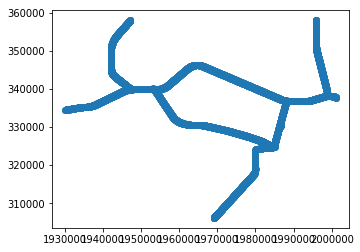

In [4]:
lrs_gdf.plot()

In [39]:
#------------------------------------------------------------------------------
df = pd.merge(df1, df2, 
              left_index=True, right_index=True, 
              suffixes=['_start', '_end'])
df.drop(columns=['RouteID_end'], inplace=True)
df.rename(columns={'RouteID_start' : 'RouteID',
                   'SRMP_start' : 'begSRMP',
                   'AheadBackI_start' : 'begAB',
                   'ARM_start' : 'begARM',
                   'SRMP_end' : 'endSRMP',
                   'AheadBackI_end' : 'endAB',
                   'ARM_end' : 'endARM'},
          inplace=True)
df = df.reindex(['RouteID', 'begSRMP', 'begAB', 'endSRMP', 'endAB',
                 'begARM', 'endARM'], 
                 axis=1)
df['direction'] = df.index.map(get_dir)
df.index.name = 'tmc'
df = df.sort_values(['RouteID', 'direction', 'begSRMP'])
df['length'] = df_tmc['miles']
df['lenARM'] = (df.endARM - df.begARM).map(abs)
df = pd.merge(df, df_sl, left_index=True, right_index=True, how='left')
df.to_csv('tmc4.csv')

### Speed Limit

In [15]:
p_gis = '../RMAS-local/4 - GIS/Washington2017'
sl_shp = 'SL2017.shp'
tmc_shp = 'Washington2017.shp'

sl_f = os.path.join(p_gis, sl_shp)
tmc_f = os.path.join(p_gis, tmc_shp)

# load points from lrs file within bounding box
sl_gdf = GeoDataFrame.from_file(sl_f)#, bbox=bbox)
sl_gdf = sl_gdf[sl_gdf.RouteID.map(lambda x: x in cors)]

tmc_gdf = GeoDataFrame.from_file(tmc_f)
tmc_gdf = tmc_gdf[tmc_gdf.Tmc.map(lambda x : x in df_tmc.index)]
tmc_gdf = tmc_gdf.to_crs(lrs_crs)
tmc_gdf2 = tmc_gdf.copy()
tmc_buf = GeoDataFrame(tmc_gdf, geometry=tmc_gdf2.buffer(300))

In [18]:
line = tmc_gdf2.geometry.iloc[0]
line.coords[-1]

(1975910.5056965887, 341732.24089609616)

In [ ]:
res_df = pd.DataFrame()

for i, row in tmc_gdf2.iterrows():
    tmc = row['Tmc']
    route_id = row['RoadNumber']
    line = row.geometry
    n_interp = int(line.length / 52.8)
    
    geom = [line.interpolate(52.8 * x) for x in range(0, n_interp)]
    
    df = GeoDataFrame({'sl' : [sl] * len(geom),
                      'RouteID' : [route_id] * len(geom)}, 
                      index=range(0, len(geom)), 
                      geometry=geom, crs=lrs_crs)
    
    res_df = pd.concat([res_df, df])

In [32]:
res_df = pd.DataFrame()

for i, row in sl_gdf.iterrows():
    sl = row['LegalSpdLm']
    route_id = row['RouteID']
    line = row.geometry
    length = row.SHAPE_STLe
    n_interp = int(line.length / 52.8)
    
    geom = [line.interpolate(52.8 * x) for x in range(0, n_interp)]
    
    df = GeoDataFrame({'sl' : [sl] * len(geom),
                      'RouteID' : [route_id] * len(geom)}, 
                      index=range(0, len(geom)), 
                      geometry=geom, crs=lrs_crs)
    
    res_df = pd.concat([res_df, df])

In [33]:
df_sl = gpd.sjoin(tmc_buf, res_df, how='left', op='contains')
df_sl = df_sl[(df_sl.RoadNumber.map(int) == df_sl.RouteID.map(int)) & \
              (df_sl.sl > 0)]
df_sl = df_sl.groupby('Tmc').agg({'sl' : 'mean'})

In [35]:
df_sl = df_sl[df_sl.sl > 0]
df_sl = df_sl.groupby('Tmc').agg({'sl' : 'mean'})
#df_sl.to_csv('SW_sl_agg.csv')

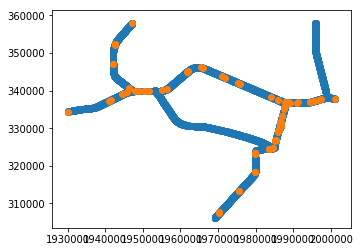

In [68]:
geom = tmc_gdf2.geometry.apply(lambda x: Point(x.coords[0]))
geom2 = tmc_gdf2.geometry.apply(lambda x: Point(x.coords[-1]))


ax = lrs_gdf.plot()
GeoDataFrame(tmc_gdf2, geometry=geom2).plot(ax=ax)

# Later...

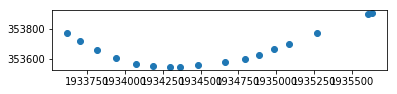

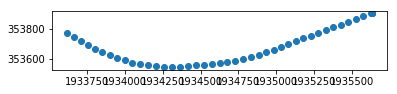

In [375]:
line = lrs_gdf.geometry[0]

geom = [Point(xy) for xy in line.coords]
GeoSeries(geom, crs=lrs_crs).plot()

xys = [line.interpolate(52.8 * x) for x in range(0, int(line.length / 52.8))]

GeoSeries(xys, crs=lrs_crs).plot()

In [384]:
int(line.length / 52.8)

40